In [1]:
%matplotlib inline
# General modules
import numpy as np
import matplotlib.pyplot as plt

# Project specific modules
from src.collision.fast_spec_col_2d import FastSpectralCollision2D
from src.solver import BC
from src.boltzmann_solver import BoltzmannSolver1D
from src.riemann.advection_1D import advection_1D
from src.solution import Solution
from src.utility import get_config

# Test 1: tend to equilibrium

Considir maxwell molecule:

$$
B_\sigma(|g|, \sigma\cdot \hat{g}) = C_0 b_0(\sigma\cdot\hat{g}).
$$

We start with initial data

$$
f(t,v) = \frac{1}{2\pi K^2}\exp\left(-\frac{v^2}{2K}\right)\left(2K - 1 + \frac{1-K}{2K}v^2\right),
$$

where $K = 1 - \exp(-t/8)/2$ with $t = 0.5$.

We solve the homogeneous Boltzmann equation with heat bath:

$$
\partial_t f = Q_\text{in}(f, f) + \tau \Delta_v f,
$$

with inelasticity parameter $e\approx 1$.

In [2]:
def bkw_f(v, t):
    K = 1 - 0.5*np.exp(-t/8)
    v_norm = (v**2)[:,None] + v**2
    return 1/(2*pi*K**2)*np.exp(-0.5*v_norm/K)*(2*K-1+0.5*v_norm*(1-K)/K)

In [3]:
def ext_Q(v, t):
    f_0 = bkw_f(v, t)
    K = 1 - 0.5*np.exp(-t/8)
    dK = np.exp(-t/8)/16
    v_norm = (v**2)[:,None] + v**2
    df = (-2/K+v_norm/(2*K**2))*f_0 + 1/(2*pi*K**2)*np.exp(-v_norm/(2*K))*(2-v_norm/(2*K**2))
    df = df*dK
    return df

In [4]:
# Import config.json file
config_2d = get_config('./src/configs/config_0d_2d.json')
# Prepare collision
Q = FastSpectralCollision2D(config_2d)

In [5]:
from math import pi
%time np.max(np.abs(Q.col_sep(bkw_f(Q.v, 0.5)) - ext_Q(Q.v, 0.5)))

CPU times: user 16.1 ms, sys: 6.08 ms, total: 22.2 ms
Wall time: 18.1 ms


0.01183549231285315

In [7]:
def norm2(f):
    return np.sum(np.abs(f)**2)*Q.dv**2

In [16]:
from src.utility import RK4
from tqdm import tnrange

tau = 1e-6
# Set up parameters
dt = 0.05
t = 0

# Initialize
f = bkw_f(Q.v, 0.)
fs = [f]
ts = [t]

print("Initial density: {}".format(np.sum(f)*Q.dv**2))

for n in tnrange(4000):
    f = RK4(f, Q.col_heat, tau, dt)
    t += dt
    fs.append(f)
    ts.append(t)
    
print("Check whether we it converges to equilibruim: {}".format(norm2(fs[-2] - fs[-1])))

Initial density: 1.000000000000001



Check whether we it converges to equilibruim: nan


In [17]:
%%time
f_eq = fs[-1]
errs = []
T = []
for f in fs:
    T.append(0.5*np.sum(f*(Q.v**2 + Q.v[:,None]**2))*Q.dv**2)
    errs.append(norm2(f - f_eq))

CPU times: user 105 ms, sys: 4.72 ms, total: 110 ms
Wall time: 108 ms


## Convergence result with $e = 0.999$, $\tau = 1 - e$ and $\Delta t = 0.1$.

The following log-log plot shows the exponential decay:

$$
\|f - f_{\infty}\|_{L^1_2} = O(e^{-\lambda t}).
$$

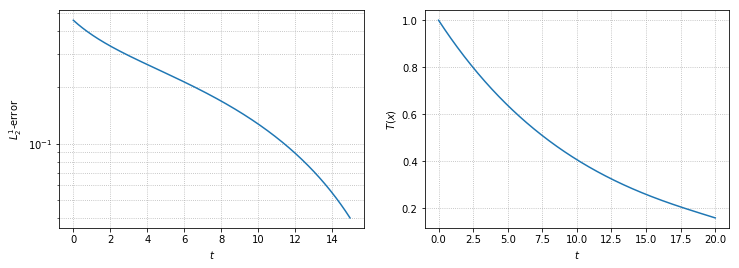

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))
ax[0].grid(which='both', linestyle=':')
ax[0].set_xlabel(r'$t$')
ax[0].set_ylabel(r'$L^1_2$-error')
ax[0].semilogy(ts[:300], errs[:300])

ax[1].grid(which='both', linestyle=':')
ax[1].set_xlabel(r'$t$')
ax[1].set_ylabel(r'$T(x)$')
ax[1].plot(ts, T)
# plt.savefig('convergence.pdf')

# Test 2: group

Considier the initial data as a Maxwellian with:

$$
(\rho, u, T) = (1 + 0.1\sigma, 0, 1),
$$

where $\sigma$ is a random variable with normal distribution:

$$
\sigma \sim \mathcal{N}(0, 0.1).
$$

We solve the inhomogeneous equation:

$$
\partial_t f + v\cdot\nabla f = Q_\text{in}(f, f) + \tau\Delta f,
$$

with $1$D in $x$ and $2$D in $v$.

In [10]:
from math import pi
def maxwellian_vectorized(v, u, T, rho):
    return rho[:,None,None]/(2*pi*T)*np.exp(-((v-u)[:,None]**2+v**2)/(2*T))

In [11]:
# Import config.json file
config_2d = get_config('./src/configs/config_2D.json')
config_2d.e = 0.9
# Prepare collision
Q = FastSpectralCollision2D(config_2d)

In [9]:
soln = Solution(config_2d)
x, v, _ = soln.c_centers
x, v = x[:,0,0], v[0,:,0]

ValueError: not enough values to unpack (expected 3, got 2)

## Initialization and check

Initial time: 0


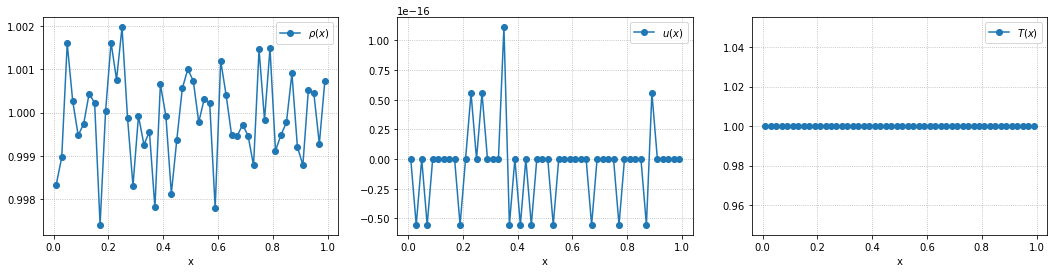

In [14]:
rho = 1. + 0.1*np.random.normal(0, 0.1, x.shape[0])
f0 = np.empty(soln.f.shape)
f0 = maxwellian_vectorized(v, 0., 1., rho)

#Initialize
soln.state.f = f0.copy()
soln.t = 0
# Plot
print("Initial time: {}".format(soln.t))
fig, ax = plt.subplots(1, 3, figsize=(18, 4))
ax[0].plot(x, soln.rho, '-o', label=r'$\rho(x)$')
ax[1].plot(x, soln.u[0], '-o', label=r'$u(x)$')
ax[2].plot(x, soln.T, '-o', label=r'$T(x)$')
for iax in ax:
    iax.set_xlabel(r'x')
    iax.legend()
    iax.set_xlabel
    iax.grid(which='both',linestyle=':')

In [15]:
solver = BoltzmannSolver1D(1.)

solver.bc_lower[0] = BC.periodic
solver.bc_upper[0] = BC.periodic

solver.dt = 0.002
solver.time_integrator = 'Euler'
solver.inner_steps = 2

solver.rp = advection_1D
solver.collision = Q.col_sep

In [16]:
print("Initial time: {}; time step: {}".format(soln.t, solver.dt))
solver.evolve_to_time(soln, 0.2)

Initial time: 0; time step: 0.002


## Solution at $T = 0.2$:

Final time: 0.2


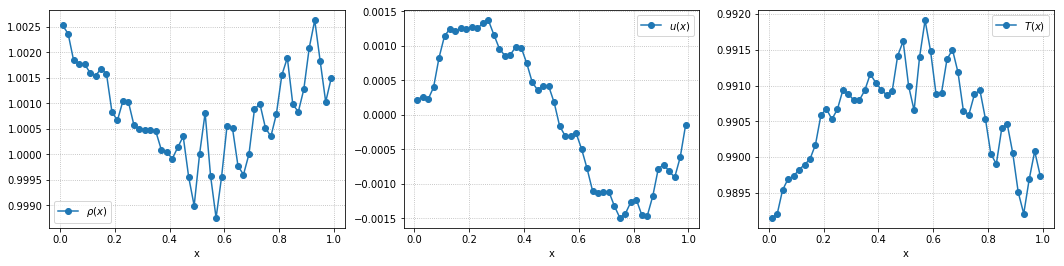

In [13]:
print("Final time: {}".format(soln.t))
fig, ax = plt.subplots(1, 3, figsize=(18, 4))

ax[0].plot(x, soln.rho, '-o', label=r'$\rho(x)$')
ax[1].plot(x, soln.u[0], '-o', label=r'$u(x)$')
ax[2].plot(x, soln.T, '-o', label=r'$T(x)$')
for iax in ax:
    iax.set_xlabel(r'x')
    iax.legend()
    iax.grid(which='both',linestyle=':')

# Test 3: Vs. Euler with source term as limiting equation

We try to compare the Boltzmann solution with Euler equation with a source term:

\begin{align}
\left\{
\begin{aligned}
&\rho_t + \nabla_x(\rho u) = 0 \\
&(\rho u)_t + \nabla_x(\rho u\otimes u + p) = 0 \\
&E_t + \nabla_x (u(E+p)) = -\frac{1}{2}\rho^2 T
\end{aligned}
\right.
\end{align}

The initial condition is chosen as:

$$
(\rho, u, T) = (1+0.1\sin(6\pi x), 0, 1).
$$

In [5]:
from math import pi
def maxwellian_vectorized(v, u, T, rho):
    return rho[:,None,None]/(2*pi*T)*np.exp(-((v-u)[:,None]**2+v**2)/(2*T))

In [6]:
# Import config.json file
config_2d = get_config('./src/configs/config_2D.json')
# Prepare collision
config_2d.e = 1. - 1e-5 
Q = FastSpectralCollision2D(config_2d)

In [7]:
soln = Solution(config_2d)
x, v, _ = soln.c_centers
x, v = x[:,0,0], v[0,:,0]

## Initialize

Initial time: 0


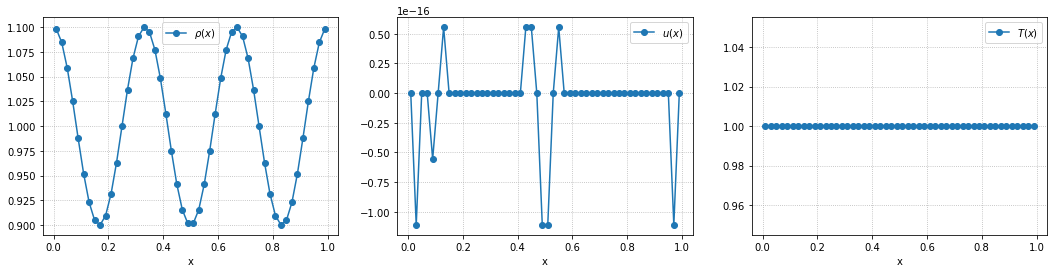

In [8]:
# rho = 1. + 0.1*np.random.normal(0, 0.1, x.shape[0])
rho = 1. + 0.1*np.cos(6*pi*x)
f0 = np.empty(soln.f.shape)
f0 = maxwellian_vectorized(v, 0., 1., rho)

#Initialize
soln.state.f = f0.copy()
soln.t = 0
# Plot
print("Initial time: {}".format(soln.t))
fig, ax = plt.subplots(1, 3, figsize=(18, 4))
ax[0].plot(x, soln.rho, '-o', label=r'$\rho(x)$')
ax[1].plot(x, soln.u[0], '-o', label=r'$u(x)$')
ax[2].plot(x, soln.T, '-o', label=r'$T(x)$')
for iax in ax:
    iax.set_xlabel(r'x')
    iax.legend()
    iax.set_xlabel
    iax.grid(which='both',linestyle=':')

In [12]:
solver = BoltzmannSolver1D(1e-5)

solver.bc_lower[0] = BC.periodic
solver.bc_upper[0] = BC.periodic

solver.dt = 0.001
solver.time_integrator = 'TPI2'

solver.inner_steps = [4, 4, 4]
solver.inner_dt = [solver.kn, 12*solver.kn, 80*solver.kn]

solver.rp = advection_1D
solver.collision = Q.col_sep

In [13]:
print("Initial time: {}; time step: {}".format(soln.t, solver.dt))
solver.evolve_to_time(soln, 0.1)

Initial time: 0; time step: 0.001


## Solution at $T = 0.1$:

Final time: 0.1


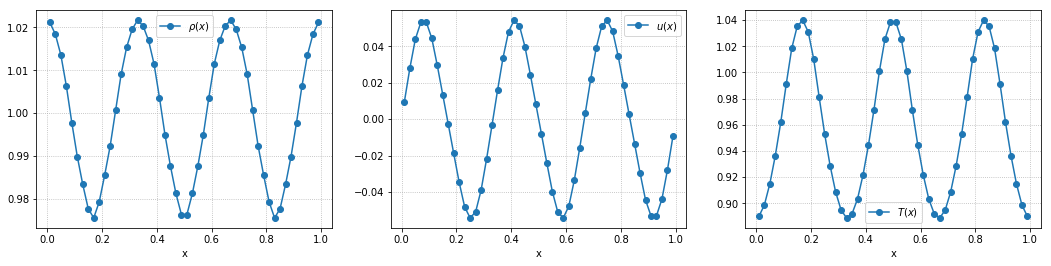

In [34]:
print("Final time: {}".format(soln.t))
fig, ax = plt.subplots(1, 3, figsize=(18, 4))

ax[0].plot(x, soln.rho, '-o', label=r'$\rho(x)$')
ax[1].plot(x, soln.u[0], '-o', label=r'$u(x)$')
ax[2].plot(x, soln.T, '-o', label=r'$T(x)$')
for iax in ax:
    iax.set_xlabel(r'x')
    iax.legend()
    iax.grid(which='both',linestyle=':')

## Clawpack Euler solver

In [49]:
from clawpack import pyclaw
from clawpack import riemann
from clawpack.riemann.euler_with_efix_1D_constants import *

gamma = 2.0 # Ratio of specific heats

def q_src(solver, state, dt):
    state.q[2] += dt*(0.25*state.q[1]**2 - 0.5*state.q[0]*state.q[2])
    
def dq_src(solver, state, dt):
    dq = np.zeros(state.q.shape)
    dq[2] = dt*(0.25*state.q[1]**2 - 0.5*state.q[0]*state.q[2])
    return dq
        
        
def setup(outdir='./_output', solver_type='sharpclaw',
          kernel_language='Python',disable_output=False):

    if kernel_language =='Python':
        rs = riemann.euler_1D_py.euler_hllc_1D
    elif kernel_language =='Fortran':
        rs = riemann.euler_with_efix_1D

    if solver_type=='sharpclaw':
        solver = pyclaw.SharpClawSolver1D(rs)
    elif solver_type=='classic':
        solver = pyclaw.ClawSolver1D(rs)

    solver.kernel_language = kernel_language
#     solver.step_source = q_src
#     solver.source_split = 1
    solver.dq_src = dq_src
    solver.bc_lower[0]=pyclaw.BC.periodic
    solver.bc_upper[0]=pyclaw.BC.periodic

    mx = config_2d.nx
    x = pyclaw.Dimension(config_2d.xmin,config_2d.xmax,mx,name='x')
    domain = pyclaw.Domain([x])
    state = pyclaw.State(domain,num_eqn)

    state.problem_data['gamma'] = gamma
    state.problem_data['gamma1'] = gamma - 1.

    x = state.grid.x.centers
    
    T = 1.0
    state.q[density ,:] = rho
    state.q[momentum,:] = 0.
    state.q[energy  ,:] = rho*T

    claw = pyclaw.Controller()
    claw.tfinal = 0.1
    claw.solution = pyclaw.Solution(state,domain)
    claw.solver = solver
    claw.num_output_times = 10
    claw.outdir = outdir
    claw.keep_copy = True
    if disable_output:
        claw.output_format = None

    return claw

In [50]:
claw = setup()
claw.run()

2019-03-18 19:40:11,722 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-18 19:40:11,734 INFO CLAW: Solution 1 computed for time t=0.010000
2019-03-18 19:40:11,746 INFO CLAW: Solution 2 computed for time t=0.020000
2019-03-18 19:40:11,763 INFO CLAW: Solution 3 computed for time t=0.030000
2019-03-18 19:40:11,777 INFO CLAW: Solution 4 computed for time t=0.040000
2019-03-18 19:40:11,790 INFO CLAW: Solution 5 computed for time t=0.050000
2019-03-18 19:40:11,800 INFO CLAW: Solution 6 computed for time t=0.060000
2019-03-18 19:40:11,822 INFO CLAW: Solution 7 computed for time t=0.070000
2019-03-18 19:40:11,840 INFO CLAW: Solution 8 computed for time t=0.080000
2019-03-18 19:40:11,856 INFO CLAW: Solution 9 computed for time t=0.090000
2019-03-18 19:40:11,878 INFO CLAW: Solution 10 computed for time t=0.100000


{'cflmax': 0.7355419525281252,
 'dtmin': 0.033313331952263464,
 'dtmax': 0.03427715493728989,
 'numsteps': 10}

Final time: 0.1


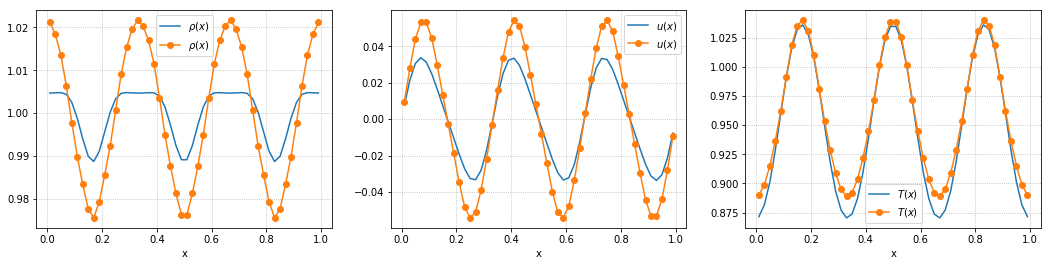

In [51]:
print("Final time: {}".format(claw.frames[-1].t))
fig, ax = plt.subplots(1, 3, figsize=(18, 4))

ax[0].plot(x, claw.frames[-1].q[0], x, soln.rho, '-o', label=r'$\rho(x)$')
ax[1].plot(x, claw.frames[-1].q[1], x, soln.u[0], '-o', label=r'$u(x)$')
ax[2].plot(x, claw.frames[-1].q[2], x, soln.T, '-o', label=r'$T(x)$')
for iax in ax:
    iax.set_xlabel(r'x')
    iax.legend()
    iax.grid(which='both',linestyle=':')

# *Solver validation*

We test the solver by setting $e = 1$ which fallback to the elastic case. This makes us to perform the Shock tube test.

The initial data are given by the Maxwellian distributions computed from the macroscopic quantities

\begin{align}
  (\rho_l, u_l, T_l) &= (1, 0, 0.5), \quad &\text{if } 0\leq x\leq 0.5, \\
  (\rho_r, u_r, T_r) &= (0.125, 0, 0.25) \quad &\text{if }0.5<x\leq 1.
\end{align}

Extrapolation boundary condition is applied.

In [17]:
# Import config.json file
config_2d = get_config('./src/configs/config_2D.json')
# Prepare collision
Q = FastSpectralCollision2D(config_2d)

In [18]:
from math import pi
def maxwellian(v, u, T, rho=1.0):
    return rho/(2*pi*T)*np.exp(-((v-u)[:,None]**2+v**2)/(2*T))

# Initialization and boundary conditions
func_l = lambda v: maxwellian(v, 0, 1.)
func_r = lambda v: maxwellian(v, 0, 0.25, 0.125)

In [19]:
soln = Solution(config_2d)
x, v, _ = soln.c_centers
x, v = x[:,0,0], v[0,:,0]

In [20]:
f0 = np.zeros(soln.f.shape)
f0[x<=.5] = func_l(v)*np.ones(x.shape)[x<=.5,None,None]
f0[x>.5] = func_r(v)*np.ones(x.shape)[x>.5,None,None]

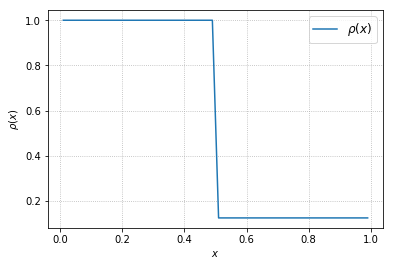

In [21]:
#Initialize
soln.state.f = f0.copy()
soln.t = 0
# Plot
fig, ax = plt.subplots()
ax.plot(x, soln.state.rho, label=r'$\rho(x)$')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$\rho(x)$')
ax.legend(fontsize='large')
ax.grid(which='both',linestyle=':')

In [22]:
solver = BoltzmannSolver1D(1e-4)

solver.bc_lower[0] = BC.extrap
solver.bc_upper[0] = BC.extrap

solver.dt = 0.002
solver.time_integrator = 'TPI3'
solver.inner_steps = [3, 3, 3]
solver.inner_dt = [1e-4, 3*1e-4, 6*1e-4]

solver.rp = advection_1D
solver.collision = Q.col_sep

In [ ]:
print("Initial time: {}; time step: {}".format(soln.t, solver.dt))
solver.evolve_to_time(soln, 0.1)

Final time: 0.1


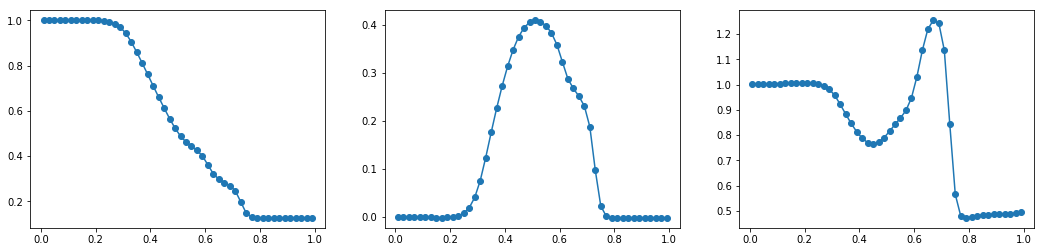

In [24]:
print("Final time: {}".format(soln.t))
fig, ax = plt.subplots(1, 3, figsize=(18, 4))
# ax[0].plot(x, euler.state.rho, label=r'Euler: $\rho(x)$')
# ax[1].plot(x, euler.state.u[0], label=r'Euler: $u(x)$')
# ax[2].plot(x, euler.state.E/soln.state.rho - 0.5*euler.state.u[0]**2 - 0.5*euler.state.u[1]**2, label=r'Euler: $T(x)$')

ax[0].plot(x, soln.rho, '-o', label=r'PFE: $\rho(x)$')
ax[1].plot(x, soln.u[0], '-o', label=r'PFE: $u(x)$')
ax[2].plot(x, soln.T, '-o', label=r'PFE: $T(x)$')

## Save data

In [10]:
np.savez('./data_figs/e1.0kn-5_pfe.npz', soln.state.f)

In [15]:
euler = Solution(config_2d)
pfe = Solution(config_2d)
euler.state.f = np.load('./data_figs/e0.8kn-2_euler.npz')['arr_0']
pfe.state.f = np.load('./data_figs/e0.8kn-2_pfe.npz')['arr_0']

0.10000000000000007


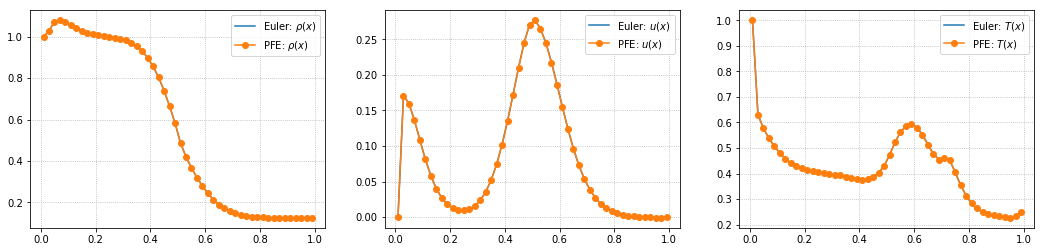

In [17]:
print(soln.state.t)
fig, ax = plt.subplots(1, 3, figsize=(18, 4))
ax[0].plot(x, euler.state.rho, label=r'Euler: $\rho(x)$')
ax[1].plot(x, euler.state.u[0], label=r'Euler: $u(x)$')
ax[2].plot(x, euler.state.E/soln.state.rho - 0.5*euler.state.u[0]**2 - 0.5*euler.state.u[1]**2, label=r'Euler: $T(x)$')

ax[0].plot(x, pfe.state.rho, '-o', label=r'PFE: $\rho(x)$')
ax[1].plot(x, pfe.state.u[0], '-o', label=r'PFE: $u(x)$')
ax[2].plot(x, pfe.state.E/soln.state.rho - 0.5*pfe.state.u[0]**2 - 0.5*pfe.state.u[1]**2, '-o', label=r'PFE: $T(x)$')

for i in range(3):
    ax[i].legend()
    ax[i].grid(which='both',linestyle=':')
    
plt.savefig('./data_figs/e0.8kn-2.pdf')

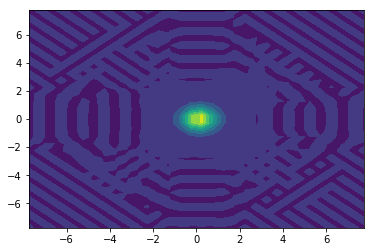

In [84]:
"""Plot the contour in velocity space for given index i"""
i = 28
fig, ax = plt.subplots()
cs = ax.contourf(euler.c_centers[-2][i], euler.c_centers[-1][i], euler.state.f[20])

# ax.clabel(cs, inline=0.5)
plt.savefig('./data_figs/e0.8kn-2_f.pdf')

In [75]:
rho_e_3 = np.copy(soln.state.rho)

0.1500000000000001


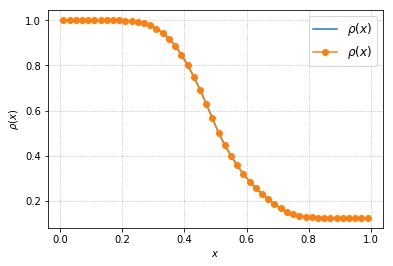

In [82]:
print(soln.state.t)
fig, ax = plt.subplots()
ax.plot(x, soln.state.rho, x, rho_e_3, 'o-', label=r'$\rho(x)$')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$\rho(x)$')
ax.legend(fontsize='large')
ax.grid(which='both',linestyle=':')